# <font color='#cec748'>This notebook is to get the filter plots</font>

## <font color='#e55730' size=3 >Imports</font>

In [1]:
from dustmaps.config import config
config.reset()

In [2]:
import numpy as np
import math
import os

from astropy.table import QTable, Table, Column

import inspect
import scipy.stats as stats
import warnings
from numpy import inf

## <font color='#e55730' size=3 >Plotting imports and settings</font>

In [3]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
import matplotlib.ticker
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as patches
from matplotlib import rcParams

%matplotlib ipympl
plt.style.use('default')
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams.update({'font.size': 14})
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['mathtext.default'] = 'regular'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'
plt.rcParams['xtick.labelsize']= 14.0
plt.rcParams['ytick.labelsize']= 14.0

## <font color='#e55730' size=3 >Values</font>

In [4]:
c = 299792.5 #km s^-1
H_0 = 70 #km s^-1 MpC^-1
R = 800
Mag_Zero_Point = 27 #mag
Mag_Zero_Point_Err = Mag_Zero_Point * 0.005

# Bands wavelength
G_Band_Wave = 4740 #AA https://prc.nao.ac.jp/citizen-science/hscv/hscdata_e.html
R_Band_Wave = 6170
I_Band_Wave = 7650
Y_Band_Wave = 8890
Z_Band_Wave = 9760


V = c/R
print(V)

374.740625


## <font color='#e55730' size=3 >Definitions</font>

In [5]:
def mag_to_flux(g_mag, g_mag_err):
    """
    Convert HSC SSP g-band magnitude to flux in microjanskys (μJy)
    with error propagation from magnitude uncertainty to flux uncertainty
    
    Parameters:
    ----------
    g_mag : float
        The g-band magnitude from HSC SSP catalog (in AB system)
    g_mag_err : float
        The standard deviation (error) of the g-band magnitude
    
    Returns:
    -------
    tuple (float, float)
        Flux in microjanskys (μJy) and its standard deviation
    
    Notes:
    -----
    Error propagation uses the derivative method:
    If f = f(x) and x has uncertainty σ_x, then σ_f = |df/dx| * σ_x
    
    For flux = 10^((8.9 - mag)/2.5) * 10^6
    df/dmag = -ln(10)/2.5 * flux
    """
    # Convert from AB magnitude to Jy
    flux_Jy = 10**((8.9 - g_mag) / 2.5)
    
    # Convert from Jy to μJy
    flux_uJy = flux_Jy * 10**6
    
    # Calculate the error using error propagation
    # The derivative of flux with respect to magnitude is:
    # dflux/dmag = -ln(10)/2.5 * flux
    ln10_div_2_5 = 0.921034  # ln(10)/2.5
    flux_err_uJy = ln10_div_2_5 * flux_uJy * g_mag_err
    
    return flux_uJy, flux_err_uJy


## <font color='#e55730' size=3 >Opening Files</font>

In [6]:
G_File_Gal_Mag = "Table_Gal_Mags_G.fits"
R_File_Gal_Mag = "Table_Gal_Mags_R.fits"
I_File_Gal_Mag = "Table_Gal_Mags_I.fits"
Y_File_Gal_Mag = "Table_Gal_Mags_Y.fits"
Z_File_Gal_Mag = "Table_Gal_Mags_Z.fits"


File_From_Alexa = "HSC_Bagpipes_table_Wichahpi.txt"

In [7]:
G_Gal_Mag = Table.read(G_File_Gal_Mag, format = 'fits')
R_Gal_Mag = Table.read(R_File_Gal_Mag, format = 'fits')
I_Gal_Mag = Table.read(I_File_Gal_Mag, format = 'fits')
Y_Gal_Mag = Table.read(Y_File_Gal_Mag, format = 'fits')
Z_Gal_Mag = Table.read(Z_File_Gal_Mag, format = 'fits')

Outputs_From_Alexa_Open = open(File_From_Alexa, "r")
Outputs_From_Alexa = Outputs_From_Alexa_Open.read()

In [8]:
with open(File_From_Alexa, 'r') as file:
    for line in file:
        # Process each line here
        print(line.strip())  # Print the line after removing leading/trailing whitespace
        print("")


Galaxy Z_Redshift G G_SD I I_SD R R_SD Y Y_SD Z Z_SD Muv_50 Muv_l Muv_u agemw_50 agemw_l agemw_u av_50 av_l av_u logsfr_50 logsfr_l logsfr_u mass_50 mass_l mass_u z_50 z_l z_u

0 0.3 29.615403270147624 0.2961540327014762 75.40564258090646 0.7540564258090646 53.590668801069285 0.5359066880106929 115.6784901853383 1.1567849018533831 106.49299617476608 1.0649299617476609 -19.20537409146954 0.2899454754204065 0.26578175973573437 4.557748750338973 0.6410566663252855 0.5437493453842714 1.3901658183519754 0.22864085886339414 0.23991266851914994 1.465464578221368 0.14593123567383293 0.14827094292020782 10.826809611621727 0.09813432187316629 0.09806709456727347 0.32262565760133377 0.012715815684156473 0.015461321970418052

1 0.4 11.717324243576217 0.11717324243576217 32.558105917070044 0.32558105917070046 28.70930332679619 0.2870930332679619 47.868217979486026 0.4786821797948603 52.5909060005087 0.5259090600050871 -18.189183706060497 0.22926601343131736 0.2740179538413372 3.6348672801143316 0.9

In [9]:
def read_columns(file_path, delimiter=None):
    """
    Reads a text file and returns a list of lists, where each inner list
    represents a column in the file.

    Args:
        file_path (str): The path to the text file.
        delimiter (str, optional): The delimiter used to separate columns.
            If None, whitespace is used. Defaults to None.

    Returns:
        list: A list of lists representing the columns of the file.
    """
    columns = []
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(delimiter)
            for i, value in enumerate(values):
                if len(columns) <= i:
                    columns.append([])
                columns[i].append(value)
    return columns

In [10]:
Mass_50_log = np.array((10.826809611621727, 10.255129195945637, 10.96845139923561, 10.874968533089955, 10.85492302943252, 10.872255483270166, 8.976547871977179))


In [11]:
Mass_50_Unlog = np.power(10, Mass_50_log)

print(Mass_50_Unlog)

[6.71134573e+10 1.79940613e+10 9.29932443e+10 7.49839878e+10
 7.16016498e+10 7.45170208e+10 9.47431613e+08]


In [12]:
G_Gal_Mag = Table(G_Gal_Mag)
R_Gal_Mag = Table(R_Gal_Mag)
I_Gal_Mag = Table(I_Gal_Mag)
Z_Gal_Mag = Table(Z_Gal_Mag)
Y_Gal_Mag = Table(Y_Gal_Mag)

In [13]:
G_Mag_Two_Gaussian_025_035 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][0]
G_Mag_Two_Gaussian_035_045 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][1]
G_Mag_Two_Gaussian_045_055 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][2]
G_Mag_Two_Gaussian_055_065 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][3]
G_Mag_Two_Gaussian_065_075 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][4]
G_Mag_Two_Gaussian_075_085 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][5]
G_Mag_Two_Gaussian_085_096 = G_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][6]


G_Mag_Two_Gaussian_SD_025_035 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][0]
G_Mag_Two_Gaussian_SD_035_045 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][1]
G_Mag_Two_Gaussian_SD_045_055 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][2]
G_Mag_Two_Gaussian_SD_055_065 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][3]
G_Mag_Two_Gaussian_SD_065_075 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][4]
G_Mag_Two_Gaussian_SD_075_085 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][5]
G_Mag_Two_Gaussian_SD_085_096 = G_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

G_Mag_Sersic_Gaussian_025_035 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][0]
G_Mag_Sersic_Gaussian_035_045 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][1]
G_Mag_Sersic_Gaussian_045_055 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][2]
G_Mag_Sersic_Gaussian_055_065 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][3]
G_Mag_Sersic_Gaussian_065_075 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][4]
G_Mag_Sersic_Gaussian_075_085 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][5]
G_Mag_Sersic_Gaussian_085_096 =G_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][6]


G_Mag_Sersic_Gaussian_SD_025_035 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][0]
G_Mag_Sersic_Gaussian_SD_035_045 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][1]
G_Mag_Sersic_Gaussian_SD_045_055 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][2]
G_Mag_Sersic_Gaussian_SD_055_065 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][3]
G_Mag_Sersic_Gaussian_SD_065_075 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][4]
G_Mag_Sersic_Gaussian_SD_075_085 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][5]
G_Mag_Sersic_Gaussian_SD_085_096 = G_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

G_Mag_SersicFixedN_GaussianFixedSigma_025_035 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][0]
G_Mag_SersicFixedN_GaussianFixedSigma_035_045 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][1]
G_Mag_SersicFixedN_GaussianFixedSigma_045_055 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][2]
G_Mag_SersicFixedN_GaussianFixedSigma_055_065 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][3]
G_Mag_SersicFixedN_GaussianFixedSigma_065_075 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][4]
G_Mag_SersicFixedN_GaussianFixedSigma_075_085 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][5]
G_Mag_SersicFixedN_GaussianFixedSigma_085_096 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][6]


G_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][0]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][1]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][2]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][3]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][4]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][5]
G_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096 = G_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

G_Mag_SersicNOne_GaussianFixedSigma_025_035 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][0]
G_Mag_SersicNOne_GaussianFixedSigma_035_045 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][1]
G_Mag_SersicNOne_GaussianFixedSigma_045_055 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][2]
G_Mag_SersicNOne_GaussianFixedSigma_055_065 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][3]
G_Mag_SersicNOne_GaussianFixedSigma_065_075 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][4]
G_Mag_SersicNOne_GaussianFixedSigma_075_085 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][5]
G_Mag_SersicNOne_GaussianFixedSigma_085_096 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][6]


G_Mag_SersicNOne_GaussianFixedSigma_SD_025_035 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][0]
G_Mag_SersicNOne_GaussianFixedSigma_SD_035_045 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][1]
G_Mag_SersicNOne_GaussianFixedSigma_SD_045_055 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][2]
G_Mag_SersicNOne_GaussianFixedSigma_SD_055_065 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][3]
G_Mag_SersicNOne_GaussianFixedSigma_SD_065_075 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][4]
G_Mag_SersicNOne_GaussianFixedSigma_SD_075_085 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][5]
G_Mag_SersicNOne_GaussianFixedSigma_SD_085_096 = G_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][6]


In [14]:
I_Mag_Two_Gaussian_025_035 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][0]
I_Mag_Two_Gaussian_035_045 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][1]
I_Mag_Two_Gaussian_045_055 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][2]
I_Mag_Two_Gaussian_055_065 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][3]
I_Mag_Two_Gaussian_065_075 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][4]
I_Mag_Two_Gaussian_075_085 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][5]
I_Mag_Two_Gaussian_085_096 = I_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][6]


I_Mag_Two_Gaussian_SD_025_035 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][0]
I_Mag_Two_Gaussian_SD_035_045 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][1]
I_Mag_Two_Gaussian_SD_045_055 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][2]
I_Mag_Two_Gaussian_SD_055_065 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][3]
I_Mag_Two_Gaussian_SD_065_075 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][4]
I_Mag_Two_Gaussian_SD_075_085 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][5]
I_Mag_Two_Gaussian_SD_085_096 = I_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

I_Mag_Sersic_Gaussian_025_035 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][0]
I_Mag_Sersic_Gaussian_035_045 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][1]
I_Mag_Sersic_Gaussian_045_055 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][2]
I_Mag_Sersic_Gaussian_055_065 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][3]
I_Mag_Sersic_Gaussian_065_075 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][4]
I_Mag_Sersic_Gaussian_075_085 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][5]
I_Mag_Sersic_Gaussian_085_096 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][6]


I_Mag_Sersic_Gaussian_SD_025_035 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][0]
I_Mag_Sersic_Gaussian_SD_035_045 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][1]
I_Mag_Sersic_Gaussian_SD_045_055 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][2]
I_Mag_Sersic_Gaussian_SD_055_065 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][3]
I_Mag_Sersic_Gaussian_SD_065_075 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][4]
I_Mag_Sersic_Gaussian_SD_075_085 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][5]
I_Mag_Sersic_Gaussian_SD_085_096 = I_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

I_Mag_SersicFixedN_GaussianFixedSigma_025_035 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][0]
I_Mag_SersicFixedN_GaussianFixedSigma_035_045 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][1]
I_Mag_SersicFixedN_GaussianFixedSigma_045_055 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][2]
I_Mag_SersicFixedN_GaussianFixedSigma_055_065 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][3]
I_Mag_SersicFixedN_GaussianFixedSigma_065_075 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][4]
I_Mag_SersicFixedN_GaussianFixedSigma_075_085 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][5]
I_Mag_SersicFixedN_GaussianFixedSigma_085_096 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][6]


I_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][0]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][1]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][2]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][3]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][4]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][5]
I_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096 = I_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

I_Mag_SersicNOne_GaussianFixedSigma_025_035 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][0]
I_Mag_SersicNOne_GaussianFixedSigma_035_045 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][1]
I_Mag_SersicNOne_GaussianFixedSigma_045_055 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][2]
I_Mag_SersicNOne_GaussianFixedSigma_055_065 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][3]
I_Mag_SersicNOne_GaussianFixedSigma_065_075 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][4]
I_Mag_SersicNOne_GaussianFixedSigma_075_085 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][5]
I_Mag_SersicNOne_GaussianFixedSigma_085_096 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][6]


I_Mag_SersicNOne_GaussianFixedSigma_SD_025_035 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][0]
I_Mag_SersicNOne_GaussianFixedSigma_SD_035_045 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][1]
I_Mag_SersicNOne_GaussianFixedSigma_SD_045_055 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][2]
I_Mag_SersicNOne_GaussianFixedSigma_SD_055_065 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][3]
I_Mag_SersicNOne_GaussianFixedSigma_SD_065_075 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][4]
I_Mag_SersicNOne_GaussianFixedSigma_SD_075_085 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][5]
I_Mag_SersicNOne_GaussianFixedSigma_SD_085_096 = I_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][6]


In [15]:
R_Mag_Two_Gaussian_025_035 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][0]
R_Mag_Two_Gaussian_035_045 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][1]
R_Mag_Two_Gaussian_045_055 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][2]
R_Mag_Two_Gaussian_055_065 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][3]
R_Mag_Two_Gaussian_065_075 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][4]
R_Mag_Two_Gaussian_075_085 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][5]
R_Mag_Two_Gaussian_085_096 = R_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][6]


R_Mag_Two_Gaussian_SD_025_035 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][0]
R_Mag_Two_Gaussian_SD_035_045 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][1]
R_Mag_Two_Gaussian_SD_045_055 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][2]
R_Mag_Two_Gaussian_SD_055_065 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][3]
R_Mag_Two_Gaussian_SD_065_075 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][4]
R_Mag_Two_Gaussian_SD_075_085 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][5]
R_Mag_Two_Gaussian_SD_085_096 = R_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

R_Mag_Sersic_Gaussian_025_035 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][0]
R_Mag_Sersic_Gaussian_035_045 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][1]
R_Mag_Sersic_Gaussian_045_055 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][2]
R_Mag_Sersic_Gaussian_055_065 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][3]
R_Mag_Sersic_Gaussian_065_075 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][4]
R_Mag_Sersic_Gaussian_075_085 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][5]
R_Mag_Sersic_Gaussian_085_096 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][6]


R_Mag_Sersic_Gaussian_SD_025_035 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][0]
R_Mag_Sersic_Gaussian_SD_035_045 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][1]
R_Mag_Sersic_Gaussian_SD_045_055 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][2]
R_Mag_Sersic_Gaussian_SD_055_065 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][3]
R_Mag_Sersic_Gaussian_SD_065_075 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][4]
R_Mag_Sersic_Gaussian_SD_075_085 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][5]
R_Mag_Sersic_Gaussian_SD_085_096 = R_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

R_Mag_SersicFixedN_GaussianFixedSigma_025_035 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][0]
R_Mag_SersicFixedN_GaussianFixedSigma_035_045 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][1]
R_Mag_SersicFixedN_GaussianFixedSigma_045_055 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][2]
R_Mag_SersicFixedN_GaussianFixedSigma_055_065 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][3]
R_Mag_SersicFixedN_GaussianFixedSigma_065_075 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][4]
R_Mag_SersicFixedN_GaussianFixedSigma_075_085 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][5]
R_Mag_SersicFixedN_GaussianFixedSigma_085_096 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][6]


R_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][0]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][1]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][2]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][3]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][4]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][5]
R_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096 = R_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

R_Mag_SersicNOne_GaussianFixedSigma_025_035 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][0]
R_Mag_SersicNOne_GaussianFixedSigma_035_045 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][1]
R_Mag_SersicNOne_GaussianFixedSigma_045_055 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][2]
R_Mag_SersicNOne_GaussianFixedSigma_055_065 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][3]
R_Mag_SersicNOne_GaussianFixedSigma_065_075 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][4]
R_Mag_SersicNOne_GaussianFixedSigma_075_085 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][5]
R_Mag_SersicNOne_GaussianFixedSigma_085_096 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][6]


R_Mag_SersicNOne_GaussianFixedSigma_SD_025_035 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][0]
R_Mag_SersicNOne_GaussianFixedSigma_SD_035_045 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][1]
R_Mag_SersicNOne_GaussianFixedSigma_SD_045_055 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][2]
R_Mag_SersicNOne_GaussianFixedSigma_SD_055_065 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][3]
R_Mag_SersicNOne_GaussianFixedSigma_SD_065_075 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][4]
R_Mag_SersicNOne_GaussianFixedSigma_SD_075_085 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][5]
R_Mag_SersicNOne_GaussianFixedSigma_SD_085_096 = R_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][6]


In [16]:
Y_Mag_Two_Gaussian_025_035 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][0]
Y_Mag_Two_Gaussian_035_045 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][1]
Y_Mag_Two_Gaussian_045_055 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][2]
Y_Mag_Two_Gaussian_055_065 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][3]
Y_Mag_Two_Gaussian_065_075 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][4]
Y_Mag_Two_Gaussian_075_085 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][5]
Y_Mag_Two_Gaussian_085_096 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][6]


Y_Mag_Two_Gaussian_SD_025_035 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][0]
Y_Mag_Two_Gaussian_SD_035_045 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][1]
Y_Mag_Two_Gaussian_SD_045_055 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][2]
Y_Mag_Two_Gaussian_SD_055_065 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][3]
Y_Mag_Two_Gaussian_SD_065_075 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][4]
Y_Mag_Two_Gaussian_SD_075_085 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][5]
Y_Mag_Two_Gaussian_SD_085_096 = Y_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Y_Mag_Sersic_Gaussian_025_035 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][0]
Y_Mag_Sersic_Gaussian_035_045 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][1]
Y_Mag_Sersic_Gaussian_045_055 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][2]
Y_Mag_Sersic_Gaussian_055_065 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][3]
Y_Mag_Sersic_Gaussian_065_075 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][4]
Y_Mag_Sersic_Gaussian_075_085 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][5]
Y_Mag_Sersic_Gaussian_085_096 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][6]


Y_Mag_Sersic_Gaussian_SD_025_035 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][0]
Y_Mag_Sersic_Gaussian_SD_035_045 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][1]
Y_Mag_Sersic_Gaussian_SD_045_055 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][2]
Y_Mag_Sersic_Gaussian_SD_055_065 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][3]
Y_Mag_Sersic_Gaussian_SD_065_075 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][4]
Y_Mag_Sersic_Gaussian_SD_075_085 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][5]
Y_Mag_Sersic_Gaussian_SD_085_096 = Y_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Y_Mag_SersicFixedN_GaussianFixedSigma_025_035 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][0]
Y_Mag_SersicFixedN_GaussianFixedSigma_035_045 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][1]
Y_Mag_SersicFixedN_GaussianFixedSigma_045_055 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][2]
Y_Mag_SersicFixedN_GaussianFixedSigma_055_065 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][3]
Y_Mag_SersicFixedN_GaussianFixedSigma_065_075 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][4]
Y_Mag_SersicFixedN_GaussianFixedSigma_075_085 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][5]
Y_Mag_SersicFixedN_GaussianFixedSigma_085_096 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][6]


Y_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][0]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][1]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][2]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][3]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][4]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][5]
Y_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096 = Y_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Y_Mag_SersicNOne_GaussianFixedSigma_025_035 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][0]
Y_Mag_SersicNOne_GaussianFixedSigma_035_045 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][1]
Y_Mag_SersicNOne_GaussianFixedSigma_045_055 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][2]
Y_Mag_SersicNOne_GaussianFixedSigma_055_065 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][3]
Y_Mag_SersicNOne_GaussianFixedSigma_065_075 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][4]
Y_Mag_SersicNOne_GaussianFixedSigma_075_085 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][5]
Y_Mag_SersicNOne_GaussianFixedSigma_085_096 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][6]


Y_Mag_SersicNOne_GaussianFixedSigma_SD_025_035 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][0]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_035_045 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][1]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_045_055 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][2]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_055_065 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][3]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_065_075 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][4]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_075_085 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][5]
Y_Mag_SersicNOne_GaussianFixedSigma_SD_085_096 = Y_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][6]


In [17]:
Z_Mag_Two_Gaussian_025_035 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][0]
Z_Mag_Two_Gaussian_035_045 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][1]
Z_Mag_Two_Gaussian_045_055 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][2]
Z_Mag_Two_Gaussian_055_065 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][3]
Z_Mag_Two_Gaussian_065_075 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][4]
Z_Mag_Two_Gaussian_075_085 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][5]
Z_Mag_Two_Gaussian_085_096 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_Array"][6]


Z_Mag_Two_Gaussian_SD_025_035 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][0]
Z_Mag_Two_Gaussian_SD_035_045 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][1]
Z_Mag_Two_Gaussian_SD_045_055 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][2]
Z_Mag_Two_Gaussian_SD_055_065 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][3]
Z_Mag_Two_Gaussian_SD_065_075 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][4]
Z_Mag_Two_Gaussian_SD_075_085 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][5]
Z_Mag_Two_Gaussian_SD_085_096 = Z_Gal_Mag["Gal_Mag_Two_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Z_Mag_Sersic_Gaussian_025_035 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][0]
Z_Mag_Sersic_Gaussian_035_045 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][1]
Z_Mag_Sersic_Gaussian_045_055 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][2]
Z_Mag_Sersic_Gaussian_055_065 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][3]
Z_Mag_Sersic_Gaussian_065_075 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][4]
Z_Mag_Sersic_Gaussian_075_085 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][5]
Z_Mag_Sersic_Gaussian_085_096 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_Array"][6]


Z_Mag_Sersic_Gaussian_SD_025_035 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][0]
Z_Mag_Sersic_Gaussian_SD_035_045 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][1]
Z_Mag_Sersic_Gaussian_SD_045_055 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][2]
Z_Mag_Sersic_Gaussian_SD_055_065 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][3]
Z_Mag_Sersic_Gaussian_SD_065_075 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][4]
Z_Mag_Sersic_Gaussian_SD_075_085 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][5]
Z_Mag_Sersic_Gaussian_SD_085_096 = Z_Gal_Mag["Gal_Mag_Sersic_Gaussian_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Z_Mag_SersicFixedN_GaussianFixedSigma_025_035 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][0]
Z_Mag_SersicFixedN_GaussianFixedSigma_035_045 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][1]
Z_Mag_SersicFixedN_GaussianFixedSigma_045_055 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][2]
Z_Mag_SersicFixedN_GaussianFixedSigma_055_065 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][3]
Z_Mag_SersicFixedN_GaussianFixedSigma_065_075 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][4]
Z_Mag_SersicFixedN_GaussianFixedSigma_075_085 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][5]
Z_Mag_SersicFixedN_GaussianFixedSigma_085_096 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_Array"][6]


Z_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][0]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][1]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][2]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][3]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][4]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][5]
Z_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096 = Z_Gal_Mag["Gal_Mag_SersicFixedN_GaussianFixedSigma_SD_Array"][6]

#################################################################################################################################################################################################################
#################################################################################################################################################################################################################

Z_Mag_SersicNOne_GaussianFixedSigma_025_035 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][0]
Z_Mag_SersicNOne_GaussianFixedSigma_035_045 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][1]
Z_Mag_SersicNOne_GaussianFixedSigma_045_055 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][2]
Z_Mag_SersicNOne_GaussianFixedSigma_055_065 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][3]
Z_Mag_SersicNOne_GaussianFixedSigma_065_075 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][4]
Z_Mag_SersicNOne_GaussianFixedSigma_075_085 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][5]
Z_Mag_SersicNOne_GaussianFixedSigma_085_096 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_Array"][6]


Z_Mag_SersicNOne_GaussianFixedSigma_SD_025_035 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][0]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_035_045 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][1]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_045_055 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][2]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_055_065 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][3]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_065_075 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][4]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_075_085 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][5]
Z_Mag_SersicNOne_GaussianFixedSigma_SD_085_096 = Z_Gal_Mag["Gal_Mag_SersicNOne_GaussianFixedSigma_SD_Array"][6]


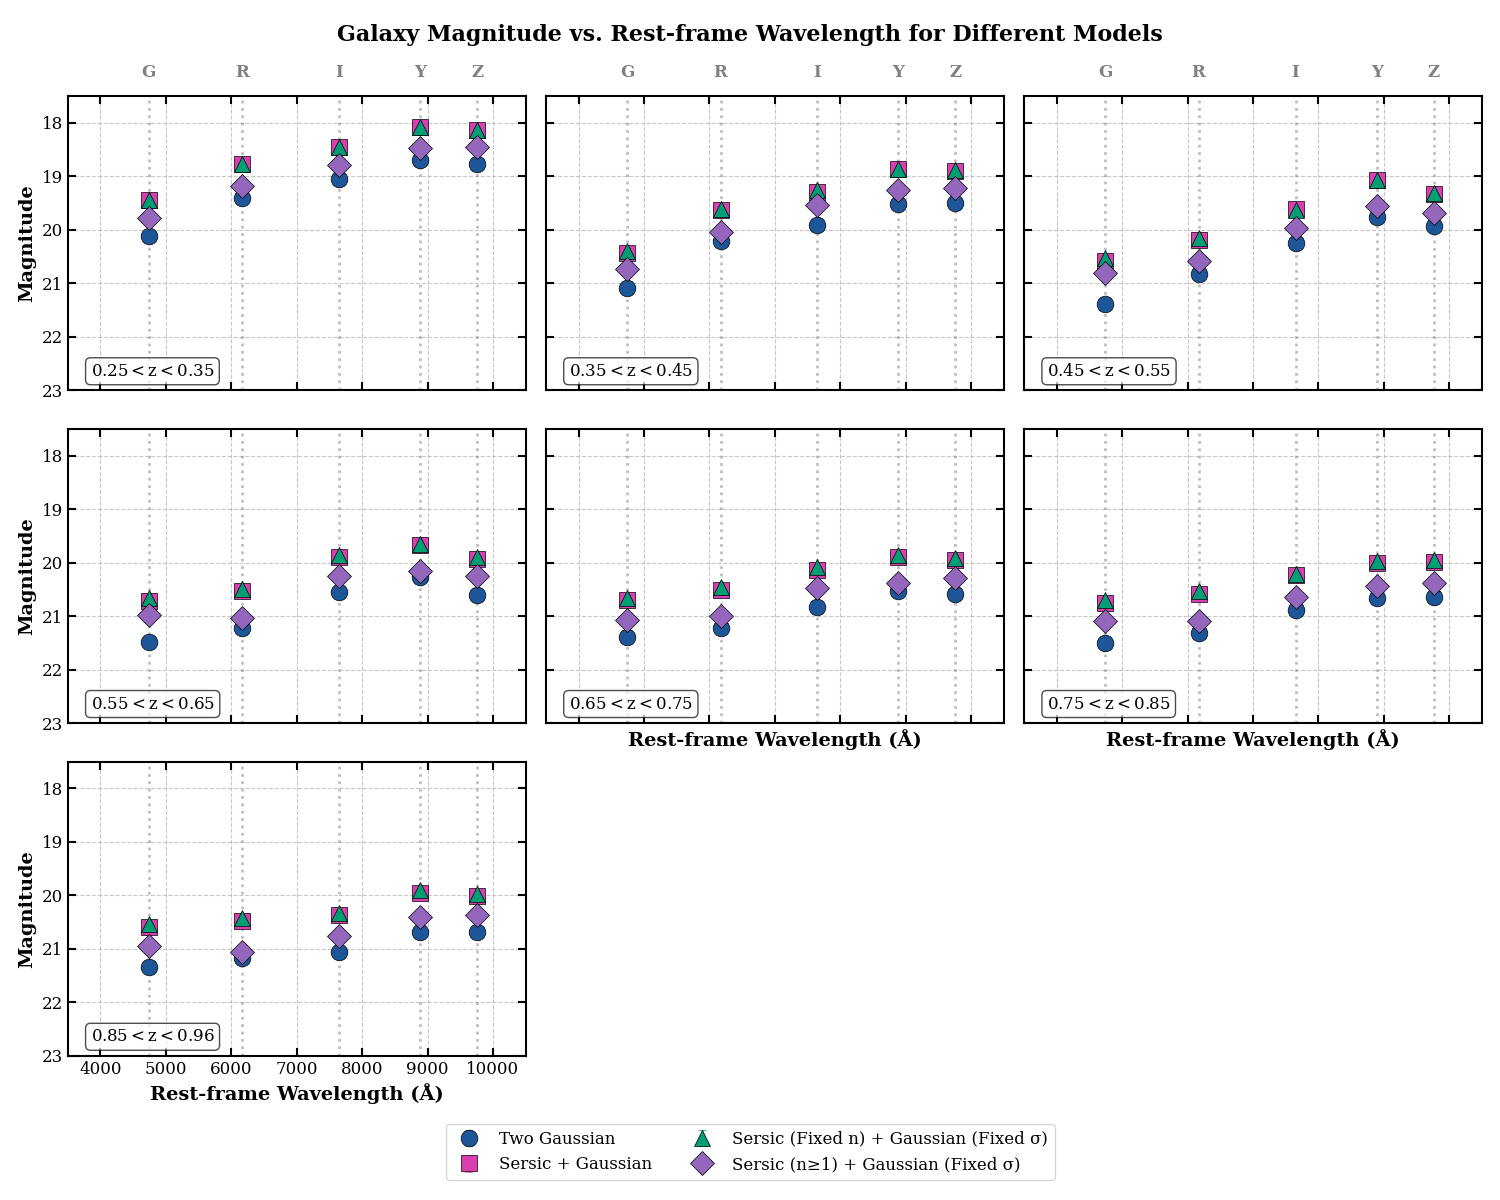

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up matplotlib parameters for publication quality
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.minor.width'] = 1
rcParams['ytick.minor.width'] = 1
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 10

# Define band wavelengths (rest-frame)
bands = {
    'G': 4740,
    'R': 6170,
    'I': 7650,
    'Y': 8890,
    'Z': 9760
}

# Use z_bins and models from your structure
filters = ["G", "I", "R", "Y", "Z"]
z_bins = [
    "025_035", "035_045", "045_055", "055_065", "065_075", "075_085", "085_096"
]
models = [
    "Two_Gaussian",
    "Two_Gaussian_SD",
    "Sersic_Gaussian",
    "Sersic_Gaussian_SD",
    "SersicFixedN_GaussianFixedSigma",
    "SersicFixedN_GaussianFixedSigma_SD",
    "SersicNOne_GaussianFixedSigma",
    "SersicNOne_GaussianFixedSigma_SD"
]

# Load data into nested dictionary
mag_data = {}
for model in models:
    mag_data[model] = {}
    for z in z_bins:
        mag_data[model][z] = {}
        for f in filters:
            var_name = f"{f}_Mag_{model}_{z}"
            mag_data[model][z][f] = globals().get(var_name)

# Map model names to plot styles
model_styles = {
    "Two_Gaussian": {"label": "Two Gaussian", "color": "#1D5799", "marker": "o"},
    "Sersic_Gaussian": {"label": "Sersic + Gaussian", "color": "#DB3EB1", "marker": "s"},
    "SersicFixedN_GaussianFixedSigma": {"label": "Sersic (Fixed n) + Gaussian (Fixed σ)", "color": "#009E73", "marker": "^"},
    "SersicNOne_GaussianFixedSigma": {"label": "Sersic (n≥1) + Gaussian (Fixed σ)", "color": "#9467BD", "marker": "D"}
}

# Redshift bin display ranges
z_display_bins = [
    (0.25, 0.35), (0.35, 0.45), (0.45, 0.55),
    (0.55, 0.65), (0.65, 0.75), (0.75, 0.85), (0.85, 0.96)
]

# Create the figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

# Remove the last two unused panels
for i in range(7, 9):
    fig.delaxes(axes[i])

for i, z_key in enumerate(z_bins):
    ax = axes[i]
    z_min, z_max = z_display_bins[i]

    for model in model_styles:
        mags = [mag_data[model][z_key][f] for f in filters]
        errors = [mag_data[model + "_SD"][z_key][f] for f in filters]

        if any(m is None for m in mags) or any(e is None for e in errors):
            continue

        # Ensure all values are scalar
        mags = [float(m) if hasattr(m, '__len__') and len(m) == 1 else m for m in mags]
        errors = [float(e) if hasattr(e, '__len__') and len(e) == 1 else e for e in errors]
        wavelengths = [bands[f] for f in filters]
        
        ax.errorbar(
            wavelengths, mags, yerr=errors,
            fmt=model_styles[model]["marker"],
            color=model_styles[model]["color"],
            label=model_styles[model]["label"] if i == 0 else None,
            markersize=12, capsize=3, elinewidth=1, markeredgecolor='black',
            markeredgewidth=0.5
        )

    ax.text(0.05, 0.05, f"${z_min} < z < {z_max}$", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    
    if i % 3 == 0:
        ax.set_ylabel("Magnitude", fontweight='bold')
    if i >= 4:
        ax.set_xlabel("Rest-frame Wavelength (Å)", fontweight='bold')

for ax in axes[:7]:
    ax.set_ylim(23, 17.5)
    ax.set_xlim(3500, 10500)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01),
           ncol=2, frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)
fig.suptitle("Galaxy Magnitude vs. Rest-frame Wavelength for Different Models",
             fontsize=16, fontweight='bold', y=0.98)

# Add band lines
for i in range(7):
    for band, wavelength in bands.items():
        axes[i].axvline(wavelength, color='gray', linestyle=':', alpha=0.5)

# Band labels for top row
for i in range(3):
    for band, wavelength in bands.items():
        ypos = axes[i].get_ylim()[1]
        trans = axes[i].get_xaxis_transform()
        axes[i].annotate(band, xy=(wavelength, 1.05), xycoords=trans,
                         ha='center', va='bottom', fontsize=12,
                         fontweight='bold', color='gray')

plt.savefig('Galaxy_Spectral_Models_Paper_Ready_Mag.png', dpi=300, bbox_inches='tight')
plt.show()


## Converting to fluxes in microJanskys

In [19]:
G_Flux_uJy_Two_Gaussian_025_035, G_Flux_uJy_Two_Gaussian_SD_025_035 = mag_to_flux(G_Mag_Two_Gaussian_025_035, G_Mag_Two_Gaussian_SD_025_035)
G_Flux_uJy_Two_Gaussian_035_045, G_Flux_uJy_Two_Gaussian_SD_035_045 = mag_to_flux(G_Mag_Two_Gaussian_035_045, G_Mag_Two_Gaussian_SD_035_045)
G_Flux_uJy_Two_Gaussian_045_055, G_Flux_uJy_Two_Gaussian_SD_045_055 = mag_to_flux(G_Mag_Two_Gaussian_045_055, G_Mag_Two_Gaussian_SD_045_055)
G_Flux_uJy_Two_Gaussian_055_065, G_Flux_uJy_Two_Gaussian_SD_055_065 = mag_to_flux(G_Mag_Two_Gaussian_055_065, G_Mag_Two_Gaussian_SD_055_065)
G_Flux_uJy_Two_Gaussian_065_075, G_Flux_uJy_Two_Gaussian_SD_065_075 = mag_to_flux(G_Mag_Two_Gaussian_065_075, G_Mag_Two_Gaussian_SD_065_075)
G_Flux_uJy_Two_Gaussian_075_085, G_Flux_uJy_Two_Gaussian_SD_075_085 = mag_to_flux(G_Mag_Two_Gaussian_075_085, G_Mag_Two_Gaussian_SD_075_085)
G_Flux_uJy_Two_Gaussian_085_096, G_Flux_uJy_Two_Gaussian_SD_085_096 = mag_to_flux(G_Mag_Two_Gaussian_085_096, G_Mag_Two_Gaussian_SD_085_096)

I_Flux_uJy_Two_Gaussian_025_035, I_Flux_uJy_Two_Gaussian_SD_025_035 = mag_to_flux(I_Mag_Two_Gaussian_025_035, I_Mag_Two_Gaussian_SD_025_035)
I_Flux_uJy_Two_Gaussian_035_045, I_Flux_uJy_Two_Gaussian_SD_035_045 = mag_to_flux(I_Mag_Two_Gaussian_035_045, I_Mag_Two_Gaussian_SD_035_045)
I_Flux_uJy_Two_Gaussian_045_055, I_Flux_uJy_Two_Gaussian_SD_045_055 = mag_to_flux(I_Mag_Two_Gaussian_045_055, I_Mag_Two_Gaussian_SD_045_055)
I_Flux_uJy_Two_Gaussian_055_065, I_Flux_uJy_Two_Gaussian_SD_055_065 = mag_to_flux(I_Mag_Two_Gaussian_055_065, I_Mag_Two_Gaussian_SD_055_065)
I_Flux_uJy_Two_Gaussian_065_075, I_Flux_uJy_Two_Gaussian_SD_065_075 = mag_to_flux(I_Mag_Two_Gaussian_065_075, I_Mag_Two_Gaussian_SD_065_075)
I_Flux_uJy_Two_Gaussian_075_085, I_Flux_uJy_Two_Gaussian_SD_075_085 = mag_to_flux(I_Mag_Two_Gaussian_075_085, I_Mag_Two_Gaussian_SD_075_085)
I_Flux_uJy_Two_Gaussian_085_096, I_Flux_uJy_Two_Gaussian_SD_085_096 = mag_to_flux(I_Mag_Two_Gaussian_085_096, I_Mag_Two_Gaussian_SD_085_096)

R_Flux_uJy_Two_Gaussian_025_035, R_Flux_uJy_Two_Gaussian_SD_025_035 = mag_to_flux(R_Mag_Two_Gaussian_025_035, R_Mag_Two_Gaussian_SD_025_035)
R_Flux_uJy_Two_Gaussian_035_045, R_Flux_uJy_Two_Gaussian_SD_035_045 = mag_to_flux(R_Mag_Two_Gaussian_035_045, R_Mag_Two_Gaussian_SD_035_045)
R_Flux_uJy_Two_Gaussian_045_055, R_Flux_uJy_Two_Gaussian_SD_045_055 = mag_to_flux(R_Mag_Two_Gaussian_045_055, R_Mag_Two_Gaussian_SD_045_055)
R_Flux_uJy_Two_Gaussian_055_065, R_Flux_uJy_Two_Gaussian_SD_055_065 = mag_to_flux(R_Mag_Two_Gaussian_055_065, R_Mag_Two_Gaussian_SD_055_065)
R_Flux_uJy_Two_Gaussian_065_075, R_Flux_uJy_Two_Gaussian_SD_065_075 = mag_to_flux(R_Mag_Two_Gaussian_065_075, R_Mag_Two_Gaussian_SD_065_075)
R_Flux_uJy_Two_Gaussian_075_085, R_Flux_uJy_Two_Gaussian_SD_075_085 = mag_to_flux(R_Mag_Two_Gaussian_075_085, R_Mag_Two_Gaussian_SD_075_085)
R_Flux_uJy_Two_Gaussian_085_096, R_Flux_uJy_Two_Gaussian_SD_085_096 = mag_to_flux(R_Mag_Two_Gaussian_085_096, R_Mag_Two_Gaussian_SD_085_096)

Y_Flux_uJy_Two_Gaussian_025_035, Y_Flux_uJy_Two_Gaussian_SD_025_035 = mag_to_flux(Y_Mag_Two_Gaussian_025_035, Y_Mag_Two_Gaussian_SD_025_035)
Y_Flux_uJy_Two_Gaussian_035_045, Y_Flux_uJy_Two_Gaussian_SD_035_045 = mag_to_flux(Y_Mag_Two_Gaussian_035_045, Y_Mag_Two_Gaussian_SD_035_045)
Y_Flux_uJy_Two_Gaussian_045_055, Y_Flux_uJy_Two_Gaussian_SD_045_055 = mag_to_flux(Y_Mag_Two_Gaussian_045_055, Y_Mag_Two_Gaussian_SD_045_055)
Y_Flux_uJy_Two_Gaussian_055_065, Y_Flux_uJy_Two_Gaussian_SD_055_065 = mag_to_flux(Y_Mag_Two_Gaussian_055_065, Y_Mag_Two_Gaussian_SD_055_065)
Y_Flux_uJy_Two_Gaussian_065_075, Y_Flux_uJy_Two_Gaussian_SD_065_075 = mag_to_flux(Y_Mag_Two_Gaussian_065_075, Y_Mag_Two_Gaussian_SD_065_075)
Y_Flux_uJy_Two_Gaussian_075_085, Y_Flux_uJy_Two_Gaussian_SD_075_085 = mag_to_flux(Y_Mag_Two_Gaussian_075_085, Y_Mag_Two_Gaussian_SD_075_085)
Y_Flux_uJy_Two_Gaussian_085_096, Y_Flux_uJy_Two_Gaussian_SD_085_096 = mag_to_flux(Y_Mag_Two_Gaussian_085_096, Y_Mag_Two_Gaussian_SD_085_096)

Z_Flux_uJy_Two_Gaussian_025_035, Z_Flux_uJy_Two_Gaussian_SD_025_035 = mag_to_flux(Z_Mag_Two_Gaussian_025_035, Z_Mag_Two_Gaussian_SD_025_035)
Z_Flux_uJy_Two_Gaussian_035_045, Z_Flux_uJy_Two_Gaussian_SD_035_045 = mag_to_flux(Z_Mag_Two_Gaussian_035_045, Z_Mag_Two_Gaussian_SD_035_045)
Z_Flux_uJy_Two_Gaussian_045_055, Z_Flux_uJy_Two_Gaussian_SD_045_055 = mag_to_flux(Z_Mag_Two_Gaussian_045_055, Z_Mag_Two_Gaussian_SD_045_055)
Z_Flux_uJy_Two_Gaussian_055_065, Z_Flux_uJy_Two_Gaussian_SD_055_065 = mag_to_flux(Z_Mag_Two_Gaussian_055_065, Z_Mag_Two_Gaussian_SD_055_065)
Z_Flux_uJy_Two_Gaussian_065_075, Z_Flux_uJy_Two_Gaussian_SD_065_075 = mag_to_flux(Z_Mag_Two_Gaussian_065_075, Z_Mag_Two_Gaussian_SD_065_075)
Z_Flux_uJy_Two_Gaussian_075_085, Z_Flux_uJy_Two_Gaussian_SD_075_085 = mag_to_flux(Z_Mag_Two_Gaussian_075_085, Z_Mag_Two_Gaussian_SD_075_085)
Z_Flux_uJy_Two_Gaussian_085_096, Z_Flux_uJy_Two_Gaussian_SD_085_096 = mag_to_flux(Z_Mag_Two_Gaussian_085_096, Z_Mag_Two_Gaussian_SD_085_096)

In [20]:
G_Flux_uJy_Sersic_Gaussian_025_035, G_Flux_uJy_Sersic_Gaussian_SD_025_035 = mag_to_flux(G_Mag_Sersic_Gaussian_025_035, G_Mag_Sersic_Gaussian_SD_025_035)
G_Flux_uJy_Sersic_Gaussian_035_045, G_Flux_uJy_Sersic_Gaussian_SD_035_045 = mag_to_flux(G_Mag_Sersic_Gaussian_035_045, G_Mag_Sersic_Gaussian_SD_035_045)
G_Flux_uJy_Sersic_Gaussian_045_055, G_Flux_uJy_Sersic_Gaussian_SD_045_055 = mag_to_flux(G_Mag_Sersic_Gaussian_045_055, G_Mag_Sersic_Gaussian_SD_045_055)
G_Flux_uJy_Sersic_Gaussian_055_065, G_Flux_uJy_Sersic_Gaussian_SD_055_065 = mag_to_flux(G_Mag_Sersic_Gaussian_055_065, G_Mag_Sersic_Gaussian_SD_055_065)
G_Flux_uJy_Sersic_Gaussian_065_075, G_Flux_uJy_Sersic_Gaussian_SD_065_075 = mag_to_flux(G_Mag_Sersic_Gaussian_065_075, G_Mag_Sersic_Gaussian_SD_065_075)
G_Flux_uJy_Sersic_Gaussian_075_085, G_Flux_uJy_Sersic_Gaussian_SD_075_085 = mag_to_flux(G_Mag_Sersic_Gaussian_075_085, G_Mag_Sersic_Gaussian_SD_075_085)
G_Flux_uJy_Sersic_Gaussian_085_096, G_Flux_uJy_Sersic_Gaussian_SD_085_096 = mag_to_flux(G_Mag_Sersic_Gaussian_085_096, G_Mag_Sersic_Gaussian_SD_085_096)

I_Flux_uJy_Sersic_Gaussian_025_035, I_Flux_uJy_Sersic_Gaussian_SD_025_035 = mag_to_flux(I_Mag_Sersic_Gaussian_025_035, I_Mag_Sersic_Gaussian_SD_025_035)
I_Flux_uJy_Sersic_Gaussian_035_045, I_Flux_uJy_Sersic_Gaussian_SD_035_045 = mag_to_flux(I_Mag_Sersic_Gaussian_035_045, I_Mag_Sersic_Gaussian_SD_035_045)
I_Flux_uJy_Sersic_Gaussian_045_055, I_Flux_uJy_Sersic_Gaussian_SD_045_055 = mag_to_flux(I_Mag_Sersic_Gaussian_045_055, I_Mag_Sersic_Gaussian_SD_045_055)
I_Flux_uJy_Sersic_Gaussian_055_065, I_Flux_uJy_Sersic_Gaussian_SD_055_065 = mag_to_flux(I_Mag_Sersic_Gaussian_055_065, I_Mag_Sersic_Gaussian_SD_055_065)
I_Flux_uJy_Sersic_Gaussian_065_075, I_Flux_uJy_Sersic_Gaussian_SD_065_075 = mag_to_flux(I_Mag_Sersic_Gaussian_065_075, I_Mag_Sersic_Gaussian_SD_065_075)
I_Flux_uJy_Sersic_Gaussian_075_085, I_Flux_uJy_Sersic_Gaussian_SD_075_085 = mag_to_flux(I_Mag_Sersic_Gaussian_075_085, I_Mag_Sersic_Gaussian_SD_075_085)
I_Flux_uJy_Sersic_Gaussian_085_096, I_Flux_uJy_Sersic_Gaussian_SD_085_096 = mag_to_flux(I_Mag_Sersic_Gaussian_085_096, I_Mag_Sersic_Gaussian_SD_085_096)

R_Flux_uJy_Sersic_Gaussian_025_035, R_Flux_uJy_Sersic_Gaussian_SD_025_035 = mag_to_flux(R_Mag_Sersic_Gaussian_025_035, R_Mag_Sersic_Gaussian_SD_025_035)
R_Flux_uJy_Sersic_Gaussian_035_045, R_Flux_uJy_Sersic_Gaussian_SD_035_045 = mag_to_flux(R_Mag_Sersic_Gaussian_035_045, R_Mag_Sersic_Gaussian_SD_035_045)
R_Flux_uJy_Sersic_Gaussian_045_055, R_Flux_uJy_Sersic_Gaussian_SD_045_055 = mag_to_flux(R_Mag_Sersic_Gaussian_045_055, R_Mag_Sersic_Gaussian_SD_045_055)
R_Flux_uJy_Sersic_Gaussian_055_065, R_Flux_uJy_Sersic_Gaussian_SD_055_065 = mag_to_flux(R_Mag_Sersic_Gaussian_055_065, R_Mag_Sersic_Gaussian_SD_055_065)
R_Flux_uJy_Sersic_Gaussian_065_075, R_Flux_uJy_Sersic_Gaussian_SD_065_075 = mag_to_flux(R_Mag_Sersic_Gaussian_065_075, R_Mag_Sersic_Gaussian_SD_065_075)
R_Flux_uJy_Sersic_Gaussian_075_085, R_Flux_uJy_Sersic_Gaussian_SD_075_085 = mag_to_flux(R_Mag_Sersic_Gaussian_075_085, R_Mag_Sersic_Gaussian_SD_075_085)
R_Flux_uJy_Sersic_Gaussian_085_096, R_Flux_uJy_Sersic_Gaussian_SD_085_096 = mag_to_flux(R_Mag_Sersic_Gaussian_085_096, R_Mag_Sersic_Gaussian_SD_085_096)

Y_Flux_uJy_Sersic_Gaussian_025_035, Y_Flux_uJy_Sersic_Gaussian_SD_025_035 = mag_to_flux(Y_Mag_Sersic_Gaussian_025_035, Y_Mag_Sersic_Gaussian_SD_025_035)
Y_Flux_uJy_Sersic_Gaussian_035_045, Y_Flux_uJy_Sersic_Gaussian_SD_035_045 = mag_to_flux(Y_Mag_Sersic_Gaussian_035_045, Y_Mag_Sersic_Gaussian_SD_035_045)
Y_Flux_uJy_Sersic_Gaussian_045_055, Y_Flux_uJy_Sersic_Gaussian_SD_045_055 = mag_to_flux(Y_Mag_Sersic_Gaussian_045_055, Y_Mag_Sersic_Gaussian_SD_045_055)
Y_Flux_uJy_Sersic_Gaussian_055_065, Y_Flux_uJy_Sersic_Gaussian_SD_055_065 = mag_to_flux(Y_Mag_Sersic_Gaussian_055_065, Y_Mag_Sersic_Gaussian_SD_055_065)
Y_Flux_uJy_Sersic_Gaussian_065_075, Y_Flux_uJy_Sersic_Gaussian_SD_065_075 = mag_to_flux(Y_Mag_Sersic_Gaussian_065_075, Y_Mag_Sersic_Gaussian_SD_065_075)
Y_Flux_uJy_Sersic_Gaussian_075_085, Y_Flux_uJy_Sersic_Gaussian_SD_075_085 = mag_to_flux(Y_Mag_Sersic_Gaussian_075_085, Y_Mag_Sersic_Gaussian_SD_075_085)
Y_Flux_uJy_Sersic_Gaussian_085_096, Y_Flux_uJy_Sersic_Gaussian_SD_085_096 = mag_to_flux(Y_Mag_Sersic_Gaussian_085_096, Y_Mag_Sersic_Gaussian_SD_085_096)

Z_Flux_uJy_Sersic_Gaussian_025_035, Z_Flux_uJy_Sersic_Gaussian_SD_025_035 = mag_to_flux(Z_Mag_Sersic_Gaussian_025_035, Z_Mag_Sersic_Gaussian_SD_025_035)
Z_Flux_uJy_Sersic_Gaussian_035_045, Z_Flux_uJy_Sersic_Gaussian_SD_035_045 = mag_to_flux(Z_Mag_Sersic_Gaussian_035_045, Z_Mag_Sersic_Gaussian_SD_035_045)
Z_Flux_uJy_Sersic_Gaussian_045_055, Z_Flux_uJy_Sersic_Gaussian_SD_045_055 = mag_to_flux(Z_Mag_Sersic_Gaussian_045_055, Z_Mag_Sersic_Gaussian_SD_045_055)
Z_Flux_uJy_Sersic_Gaussian_055_065, Z_Flux_uJy_Sersic_Gaussian_SD_055_065 = mag_to_flux(Z_Mag_Sersic_Gaussian_055_065, Z_Mag_Sersic_Gaussian_SD_055_065)
Z_Flux_uJy_Sersic_Gaussian_065_075, Z_Flux_uJy_Sersic_Gaussian_SD_065_075 = mag_to_flux(Z_Mag_Sersic_Gaussian_065_075, Z_Mag_Sersic_Gaussian_SD_065_075)
Z_Flux_uJy_Sersic_Gaussian_075_085, Z_Flux_uJy_Sersic_Gaussian_SD_075_085 = mag_to_flux(Z_Mag_Sersic_Gaussian_075_085, Z_Mag_Sersic_Gaussian_SD_075_085)
Z_Flux_uJy_Sersic_Gaussian_085_096, Z_Flux_uJy_Sersic_Gaussian_SD_085_096 = mag_to_flux(Z_Mag_Sersic_Gaussian_085_096, Z_Mag_Sersic_Gaussian_SD_085_096)

In [21]:
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_025_035, G_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_035_045, G_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_045_055, G_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_055_065, G_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_065_075, G_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_075_085, G_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085)
G_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096 = mag_to_flux(G_Mag_SersicFixedN_GaussianFixedSigma_085_096, G_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096)

I_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_025_035, I_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_035_045, I_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_045_055, I_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_055_065, I_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_065_075, I_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_075_085, I_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085)
I_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096, I_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096 = mag_to_flux(I_Mag_SersicFixedN_GaussianFixedSigma_085_096, I_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096)

R_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_025_035, R_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_035_045, R_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_045_055, R_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_055_065, R_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_065_075, R_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_075_085, R_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085)
R_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096, R_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096 = mag_to_flux(R_Mag_SersicFixedN_GaussianFixedSigma_085_096, R_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096)

Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_025_035, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_035_045, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_045_055, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_055_065, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_065_075, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_075_085, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085)
Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096, Y_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096 = mag_to_flux(Y_Mag_SersicFixedN_GaussianFixedSigma_085_096, Y_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096)

Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_025_035, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_025_035)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_035_045, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_035_045)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_045_055, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_045_055)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_055_065, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_055_065)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_065_075, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_065_075)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_075_085, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_075_085)
Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096, Z_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096 = mag_to_flux(Z_Mag_SersicFixedN_GaussianFixedSigma_085_096, Z_Mag_SersicFixedN_GaussianFixedSigma_SD_085_096)

In [22]:
G_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_025_035, G_Mag_SersicNOne_GaussianFixedSigma_SD_025_035)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_035_045, G_Mag_SersicNOne_GaussianFixedSigma_SD_035_045)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_045_055, G_Mag_SersicNOne_GaussianFixedSigma_SD_045_055)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_055_065, G_Mag_SersicNOne_GaussianFixedSigma_SD_055_065)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_065_075, G_Mag_SersicNOne_GaussianFixedSigma_SD_065_075)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_075_085, G_Mag_SersicNOne_GaussianFixedSigma_SD_075_085)
G_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096 = mag_to_flux(G_Mag_SersicNOne_GaussianFixedSigma_085_096, G_Mag_SersicNOne_GaussianFixedSigma_SD_085_096)

I_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_025_035, I_Mag_SersicNOne_GaussianFixedSigma_SD_025_035)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_035_045, I_Mag_SersicNOne_GaussianFixedSigma_SD_035_045)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_045_055, I_Mag_SersicNOne_GaussianFixedSigma_SD_045_055)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_055_065, I_Mag_SersicNOne_GaussianFixedSigma_SD_055_065)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_065_075, I_Mag_SersicNOne_GaussianFixedSigma_SD_065_075)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_075_085, I_Mag_SersicNOne_GaussianFixedSigma_SD_075_085)
I_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096 = mag_to_flux(I_Mag_SersicNOne_GaussianFixedSigma_085_096, I_Mag_SersicNOne_GaussianFixedSigma_SD_085_096)

R_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_025_035, R_Mag_SersicNOne_GaussianFixedSigma_SD_025_035)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_035_045, R_Mag_SersicNOne_GaussianFixedSigma_SD_035_045)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_045_055, R_Mag_SersicNOne_GaussianFixedSigma_SD_045_055)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_055_065, R_Mag_SersicNOne_GaussianFixedSigma_SD_055_065)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_065_075, R_Mag_SersicNOne_GaussianFixedSigma_SD_065_075)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_075_085, R_Mag_SersicNOne_GaussianFixedSigma_SD_075_085)
R_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096 = mag_to_flux(R_Mag_SersicNOne_GaussianFixedSigma_085_096, R_Mag_SersicNOne_GaussianFixedSigma_SD_085_096)

Y_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_025_035, Y_Mag_SersicNOne_GaussianFixedSigma_SD_025_035)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_035_045, Y_Mag_SersicNOne_GaussianFixedSigma_SD_035_045)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_045_055, Y_Mag_SersicNOne_GaussianFixedSigma_SD_045_055)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_055_065, Y_Mag_SersicNOne_GaussianFixedSigma_SD_055_065)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_065_075, Y_Mag_SersicNOne_GaussianFixedSigma_SD_065_075)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_075_085, Y_Mag_SersicNOne_GaussianFixedSigma_SD_075_085)
Y_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096 = mag_to_flux(Y_Mag_SersicNOne_GaussianFixedSigma_085_096, Y_Mag_SersicNOne_GaussianFixedSigma_SD_085_096)

Z_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_025_035, Z_Mag_SersicNOne_GaussianFixedSigma_SD_025_035)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_035_045, Z_Mag_SersicNOne_GaussianFixedSigma_SD_035_045)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_045_055, Z_Mag_SersicNOne_GaussianFixedSigma_SD_045_055)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_055_065, Z_Mag_SersicNOne_GaussianFixedSigma_SD_055_065)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_065_075, Z_Mag_SersicNOne_GaussianFixedSigma_SD_065_075)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_075_085, Z_Mag_SersicNOne_GaussianFixedSigma_SD_075_085)
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096 = mag_to_flux(Z_Mag_SersicNOne_GaussianFixedSigma_085_096, Z_Mag_SersicNOne_GaussianFixedSigma_SD_085_096)

In [23]:
Z_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096

(25.840417692580143, 1.1321172704966735)

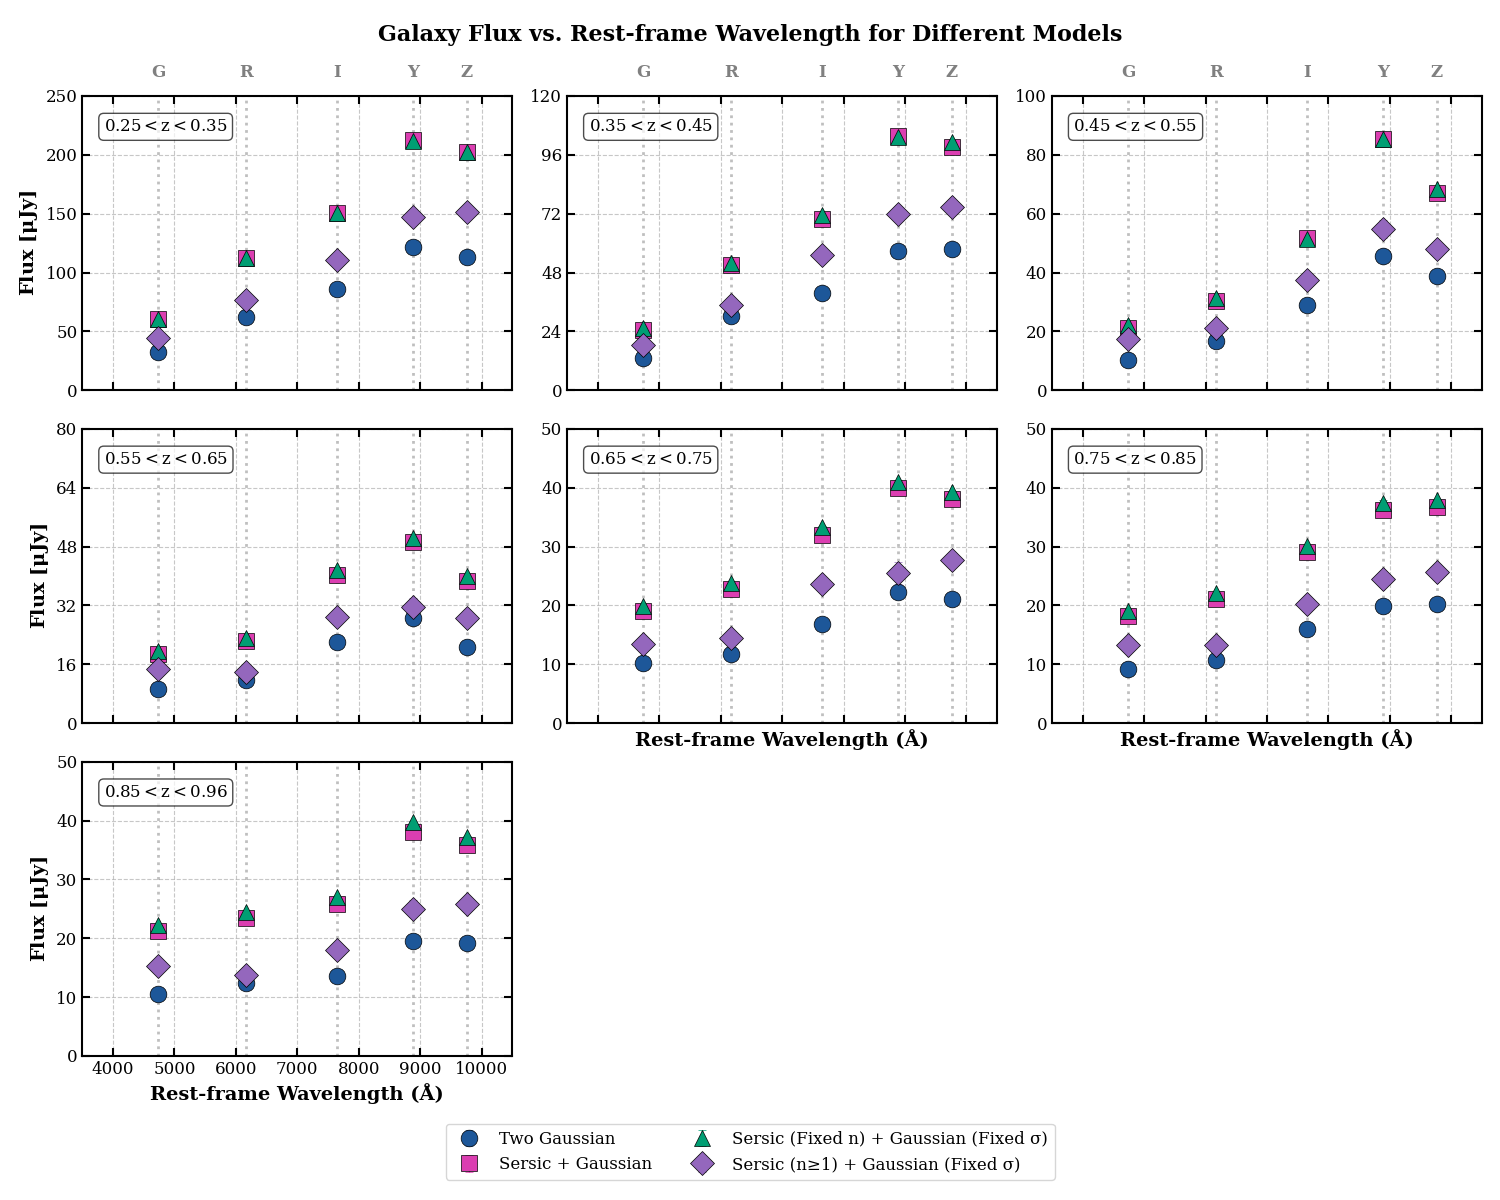

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set up matplotlib parameters for publication quality
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 12
rcParams['axes.linewidth'] = 1.5
rcParams['xtick.major.width'] = 1.5
rcParams['ytick.major.width'] = 1.5
rcParams['xtick.minor.width'] = 1
rcParams['ytick.minor.width'] = 1
rcParams['xtick.major.size'] = 6
rcParams['ytick.major.size'] = 6
rcParams['xtick.minor.size'] = 3
rcParams['ytick.minor.size'] = 3
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12
rcParams['legend.fontsize'] = 10

# Define band wavelengths (rest-frame)
bands = {
    'G': 4740,
    'R': 6170,
    'I': 7650,
    'Y': 8890,
    'Z': 9760
}

# Use z_bins and models from your structure
filters = ["G", "I", "R", "Y", "Z"]
z_bins = [
    "025_035", "035_045", "045_055", "055_065", "065_075", "075_085", "085_096"
]
models = [
    "Flux_uJy_Two_Gaussian",
    "Flux_uJy_Two_Gaussian_SD",
    "Flux_uJy_Sersic_Gaussian",
    "Flux_uJy_Sersic_Gaussian_SD",
    "Flux_uJy_SersicFixedN_GaussianFixedSigma",
    "Flux_uJy_SersicFixedN_GaussianFixedSigma_SD",
    "Flux_uJy_SersicNOne_GaussianFixedSigma",
    "Flux_uJy_SersicNOne_GaussianFixedSigma_SD"
]

# Load data into nested dictionary
mag_data = {}
for model in models:
    mag_data[model] = {}
    for z in z_bins:
        mag_data[model][z] = {}
        for f in filters:
            var_name = f"{f}_{model}_{z}"
            mag_data[model][z][f] = globals().get(var_name)

# Map model names to plot styles
model_styles = {
    "Two_Gaussian": {"label": "Two Gaussian", "color": "#1D5799", "marker": "o"},
    "Sersic_Gaussian": {"label": "Sersic + Gaussian", "color": "#DB3EB1", "marker": "s"},
    "SersicFixedN_GaussianFixedSigma": {"label": "Sersic (Fixed n) + Gaussian (Fixed σ)", "color": "#009E73", "marker": "^"},
    "SersicNOne_GaussianFixedSigma": {"label": "Sersic (n≥1) + Gaussian (Fixed σ)", "color": "#9467BD", "marker": "D"}
}

# Redshift bin display ranges
z_display_bins = [
    (0.25, 0.35), (0.35, 0.45), (0.45, 0.55),
    (0.55, 0.65), (0.65, 0.75), (0.75, 0.85), (0.85, 0.96)
]

# Define custom y-axis limits for each panel
# You can adjust these values as needed for each panel
y_limits = [
    (0, 250),   # Panel 0: z = 0.25-0.35
    (0, 120),   # Panel 1: z = 0.35-0.45
    (0, 100),   # Panel 2: z = 0.45-0.55
    (0, 80),   # Panel 3: z = 0.55-0.65
    (0, 50),   # Panel 4: z = 0.65-0.75
    (0, 50),   # Panel 5: z = 0.75-0.85
    (0, 50)    # Panel 6: z = 0.85-0.96
]

# Create the figure
fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True)
axes = axes.flatten()

# Remove the last two unused panels
for i in range(7, 9):
    fig.delaxes(axes[i])

for i, z_key in enumerate(z_bins):
    ax = axes[i]
    z_min, z_max = z_display_bins[i]

    for short_name in model_styles:
        flux_key = f"Flux_uJy_{short_name}"
        flux_sd_key = f"{flux_key}_SD"

        if flux_key not in mag_data or flux_sd_key not in mag_data:
            continue

        mags = [mag_data[flux_key][z_key][f] for f in filters]
        errors = [mag_data[flux_sd_key][z_key][f] for f in filters]

        if any(m is None for m in mags) or any(e is None for e in errors):
            continue

        # Ensure all values are scalar
        mags = [float(m) if hasattr(m, '__len__') and len(m) == 1 else m for m in mags]
        errors = [float(e) if hasattr(e, '__len__') and len(e) == 1 else e for e in errors]
        wavelengths = [bands[f] for f in filters]
        
        ax.errorbar(
            wavelengths, mags, yerr=errors,
            fmt=model_styles[short_name]["marker"],
            color=model_styles[short_name]["color"],
            label=model_styles[short_name]["label"] if i == 0 else None,
            markersize=12, capsize=3, elinewidth=1, markeredgecolor='black',
            markeredgewidth=0.5
        )

    # Set individual y-axis limits for each panel
    ax.set_ylim(y_limits[i])
    
    # Add y-ticks appropriate for the range
    y_min, y_max = y_limits[i]
    y_step = (y_max - y_min) / 5  # 5 steps
    ax.set_yticks(np.arange(y_min, y_max + y_step, y_step))
    
    ax.text(0.05, 0.88, f"${z_min} < z < {z_max}$", transform=ax.transAxes,
            fontsize=12, bbox=dict(facecolor='white', alpha=0.7, boxstyle='round'))
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.tick_params(which='both', direction='in', top=True, right=True)
    
    if i % 3 == 0:
        ax.set_ylabel(r"Flux [$\mu$Jy]", fontweight='bold')
    if i >= 4:
        ax.set_xlabel("Rest-frame Wavelength (Å)", fontweight='bold')

# Set x-axis limits the same for all panels
for ax in axes[:7]:
    ax.set_xlim(3500, 10500)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 0.01),
           ncol=2, frameon=True, fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.12, top=0.92)
fig.suptitle("Galaxy Flux vs. Rest-frame Wavelength for Different Models",
             fontsize=16, fontweight='bold', y=0.98)

# Add band lines
for i in range(7):
    for band, wavelength in bands.items():
        axes[i].axvline(wavelength, color='gray', linestyle=':', alpha=0.5)

# Band labels for top row
for i in range(3):
    for band, wavelength in bands.items():
        ypos = axes[i].get_ylim()[1]
        trans = axes[i].get_xaxis_transform()
        axes[i].annotate(band, xy=(wavelength, 1.05), xycoords=trans,
                         ha='center', va='bottom', fontsize=12,
                         fontweight='bold', color='gray')

plt.savefig('Galaxy_Spectral_Models_Flux_Paper_Ready_Flux.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
Redshift_Ranges_Array = ["0.25<z<0.35", "0.35<z<0.45", "0.45<z<0.55", "0.55<z<0.65", "0.65<z<0.75", "0.75<z<0.85", "0.85<z<0.96"]

Redshift_Mid_Array = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.905])

Flux_Two_Gaussian = np.array([G_Flux_uJy_Two_Gaussian_025_035, G_Flux_uJy_Two_Gaussian_035_045, G_Flux_uJy_Two_Gaussian_045_055, G_Flux_uJy_Two_Gaussian_055_065, 
                              G_Flux_uJy_Two_Gaussian_065_075, G_Flux_uJy_Two_Gaussian_075_085, G_Flux_uJy_Two_Gaussian_085_096])

Flux_Sersic_Gaussian = np.array([G_Flux_uJy_Sersic_Gaussian_025_035, G_Flux_uJy_Sersic_Gaussian_035_045, G_Flux_uJy_Sersic_Gaussian_045_055, G_Flux_uJy_Sersic_Gaussian_055_065, 
                        G_Flux_uJy_Sersic_Gaussian_065_075, G_Flux_uJy_Sersic_Gaussian_075_085, G_Flux_uJy_Sersic_Gaussian_085_096])

Flux_SersicFixedN_GaussianFixedSigma = np.array([G_Flux_uJy_SersicFixedN_GaussianFixedSigma_025_035, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_035_045, 
                                        G_Flux_uJy_SersicFixedN_GaussianFixedSigma_045_055, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_055_065, 
                                        G_Flux_uJy_SersicFixedN_GaussianFixedSigma_065_075, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_075_085, 
                                        G_Flux_uJy_SersicFixedN_GaussianFixedSigma_085_096])

Flux_SersicNOne_GaussianFixedSigma = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, G_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, 
                                      G_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, G_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, 
                                      G_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, G_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, 
                                      G_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096])


Flux_Two_Gaussian_SD = np.array([G_Flux_uJy_Two_Gaussian_SD_025_035, G_Flux_uJy_Two_Gaussian_SD_035_045, G_Flux_uJy_Two_Gaussian_SD_045_055, G_Flux_uJy_Two_Gaussian_SD_055_065, 
                        G_Flux_uJy_Two_Gaussian_SD_065_075, G_Flux_uJy_Two_Gaussian_SD_075_085, G_Flux_uJy_Two_Gaussian_SD_085_096])

Flux_Sersic_Gaussian_SD = np.array([G_Flux_uJy_Sersic_Gaussian_SD_025_035, G_Flux_uJy_Sersic_Gaussian_SD_035_045, G_Flux_uJy_Sersic_Gaussian_SD_045_055, 
                           G_Flux_uJy_Sersic_Gaussian_SD_055_065, G_Flux_uJy_Sersic_Gaussian_SD_065_075, G_Flux_uJy_Sersic_Gaussian_SD_075_085, 
                           G_Flux_uJy_Sersic_Gaussian_SD_085_096])

Flux_SersicFixedN_GaussianFixedSigma_SD = np.array([G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_025_035, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_035_045, 
                                           G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_045_055, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_055_065, 
                                           G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_065_075, G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_075_085, 
                                           G_Flux_uJy_SersicFixedN_GaussianFixedSigma_SD_085_096])

Flux_SersicNOne_GaussianFixedSigma_SD = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045, 
                                         G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065, 
                                         G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075, G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085, 
                                         G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096])



#########################################################################################################################################################################################


Flux_SersicNOne_GaussianFixedSigma_All_Filters_025_035 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_025_035])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_035_045 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_035_045])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_045_055 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_045_055])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_055_065 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_055_065])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_065_075 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_065_075])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_075_085 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_075_085])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_085_096 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_085_096])

Flux_SersicNOne_GaussianFixedSigma_All_Filters = np.array([Flux_SersicNOne_GaussianFixedSigma_All_Filters_025_035, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_035_045, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_045_055, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_055_065, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_065_075, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_075_085, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_085_096])

#########################################################################################################################################################################################

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_025_035 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_025_035])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_035_045 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_035_045])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_045_055 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_045_055])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_055_065 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_055_065])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_065_075 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_065_075])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_075_085 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_075_085])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_085_096 = np.array([G_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096, 
                                                        R_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096, 
                                                        I_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096, 
                                                        Y_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096, 
                                                        Z_Flux_uJy_SersicNOne_GaussianFixedSigma_SD_085_096])

Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD = np.array([Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_025_035, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_035_045, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_045_055, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_055_065, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_065_075, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_075_085, 
                                                           Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD_085_096])

In [26]:
Table_start_a = ([(Redshift_Ranges_Array[0])])

Table_start_b = ([(Flux_Two_Gaussian[0])])
Table_start_c = ([(Flux_Sersic_Gaussian[0])])
Table_start_d = ([(Flux_SersicFixedN_GaussianFixedSigma[0])])
Table_start_e = ([(Flux_SersicNOne_GaussianFixedSigma[0])])

Table_start_f = ([(Flux_Two_Gaussian_SD[0])])
Table_start_g = ([(Flux_Sersic_Gaussian_SD[0])])
Table_start_h = ([(Flux_SersicFixedN_GaussianFixedSigma_SD[0])])
Table_start_ii = ([(Flux_SersicNOne_GaussianFixedSigma_SD[0])])

Table_b = QTable([Table_start_a, Table_start_b, Table_start_c, Table_start_d, Table_start_e, Table_start_f, Table_start_g, Table_start_h, Table_start_ii], 
                 names=("Z_Redshift", "Flux_Two_Gaussian", "Flux_Sersic_Gaussian", "Flux_SersicFixedN_GaussianFixedSigma", "Flux_SersicNOne_GaussianFixedSigma", "Flux_Two_Gaussian_SD", 
                        "Flux_Sersic_Gaussian_SD", "Flux_SersicFixedN_GaussianFixedSigma_SD", "Flux_SersicNOne_GaussianFixedSigma_SD"))



In [27]:
for i in np.arange(1,len(Flux_Two_Gaussian),1):
    a = ([(Redshift_Ranges_Array[i])])

    b = ([(Flux_Two_Gaussian[i])])
    c = ([(Flux_Sersic_Gaussian[i])])
    d = ([(Flux_SersicFixedN_GaussianFixedSigma[i])])
    e = ([(Flux_SersicNOne_GaussianFixedSigma[i])])

    f = ([(Flux_Two_Gaussian_SD[i])])
    g = ([(Flux_Sersic_Gaussian_SD[i])])
    h = ([(Flux_SersicFixedN_GaussianFixedSigma_SD[i])])
    ii = ([(Flux_SersicNOne_GaussianFixedSigma_SD[i])])

    Table_b.add_row([a,b,c,d,e,f,g,h,ii])
    

In [28]:
Table_b.write("/home/jovyan/work/stampede3/AGN-Black-Hole-Research/Table_Gal_Flux_MicroJansky.fits", overwrite = True)


In [29]:
Table_start_a = ([(Redshift_Ranges_Array[0])])
Table_start_b = ([(Redshift_Mid_Array[0])])

Table_start_c = ([(Flux_SersicNOne_GaussianFixedSigma_All_Filters[0])])
Table_start_d = ([(Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD[0])])

Table_b = QTable([Table_start_a, Table_start_b, Table_start_c, Table_start_d], names=("Z_Redshift_Range", "Z", "Flux_SersicNOne_GaussianFixedSigma", "Flux_SersicNOne_GaussianFixedSigma_SD"))


In [30]:
for i in np.arange(1,len(Flux_Two_Gaussian),1):
    a = ([(Redshift_Ranges_Array[i])])
    b = ([(Redshift_Mid_Array[i])])

    c = ([(Flux_SersicNOne_GaussianFixedSigma_All_Filters[i])])
    d = ([(Flux_SersicNOne_GaussianFixedSigma_All_Filters_SD[i])])

    Table_b.add_row([a,b,c,d])
    

In [31]:
Table_b.write("/home/jovyan/work/stampede3/AGN-Black-Hole-Research/Table_Gal_Flux_MicroJansky_For_Alexa.fits", overwrite = True)


In [32]:
Table.read("/home/jovyan/work/stampede3/AGN-Black-Hole-Research/Table_Gal_Flux_MicroJansky_For_Alexa.fits", format = 'fits')


Z_Redshift_Range,Z,Flux_SersicNOne_GaussianFixedSigma,Flux_SersicNOne_GaussianFixedSigma_SD
bytes11,float64,float64[5],float64[5]
0.25<z<0.35,0.3,60.250701881086165 .. 202.376080792399,0.06849219946273881 .. 0.4974786492840364
0.35<z<0.45,0.4,25.32552568038597 .. 101.36882344584721,0.04787856897113484 .. 0.23278158193408333
0.45<z<0.55,0.5,22.337624995707376 .. 68.42842587483209,0.040378317363805975 .. 0.3233821141356722
0.55<z<0.65,0.6,19.728792371549797 .. 40.0334669478207,0.058845450149360996 .. 0.12248639852646838
0.65<z<0.75,0.7,19.871311283977466 .. 39.34581686535938,0.03208858945891002 .. 0.13891357036605892
0.75<z<0.85,0.8,19.094953958432935 .. 37.99125878949261,0.05235464112948262 .. 0.09499231220443598
0.85<z<0.96,0.905,22.31044791679187 .. 37.25659296392665,0.035489056612265875 .. 0.1052046821005163
